# QOSF Mentorship Screening Task 4

* __Author: Shantom Borah__
* __Library Used: Qiskit__
* __Submission Date: 17-Feb-2021__

This document describes my implementation of Screening Task 4 for the QOSF Mentorship Program of Spring 2021. The objective of the problem was to build a QAOA solver for the weighted Max Cut problem. In solving this problem, I have tried to keep the general features of the QAOA algorithm separate from the specific features of the Max Cut problem, so that much of the code is reusable for solving any other combinatorial problem. Python inheritance turns out to be very useful in this regard. As a demonstration, I have included a simulation of the Max Clique problem in section 6 of this document. The contents of this document are organized as follows:

1. *Problem Description*
2. *QAOA Overview*
3. *Code Overview*
4. *Max Cut Simulations*
5. *Noisy Simulations*
6. *The Max Clique Problem*
7. *Conclusions*
8. *References*

## 1. Problem Description
In this section, I shall outline a very brief description of the Max Cut Problem. Give a weighted graph $G = (V, E)$, colour each of its vertices either *'red'* or *'blue'*, so that the sum of the weights of edges with mismatching colours on both their ends, is maximized. In other words, we are to partition the graph into two sets of vertices, so that the weight of edges which are 'cut off' by the partition is maximized. The unweighted Max Cut problem is a special case of this problem when the weights of all edges in the graph is unity.

To make this more formal, let us assign a binary value $x_v \in \{0, 1\}$ for each vertex $v \in V$ $(1$ for *'red'* and $0$ for *'blue'*, say$)$. Define the set $S \subset E$ as the set of all edges with mismatching colours on its ends.

$$ S = \{(u, v) \in E: x_u \neq x_v\}$$

Let us denote the weight of an edge $e \in E$ as $w_e$. Then, our objective is to find an assignment of the $x_v$ such that the following profit function $P$, is maximized.

$$P = \sum_{e \in S} w_e$$

As an example, consider the linear graph on the left side of the figure shown below. For a linear graph, the solution of the Max Cut problem is obviously to colour alternate edges with a different colour, as shown in the figure on the right.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

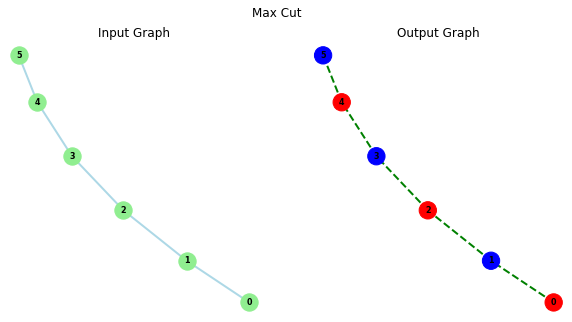

In [2]:
# Build linear graph
V = list(range(6))
E = [(i, i+1) for i in range(5)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

# Encode solution into colour map
color_map = ['red', 'blue'] * 3
cuts = ['dashed'] * len(E)

# Plot input graph
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Max Cut')
plt.subplot(121)
ax = plt.gca()
ax.set_title('Input Graph')
pos = nx.drawing.layout.spring_layout(G)
nx.draw(G, with_labels=True, node_color='lightgreen', edge_color='lightblue', 
        style='solid', width=2, ax=ax, pos=pos, font_size=8, font_weight='bold')

# Plot output graph
plt.subplot(122)
ax = plt.gca()
ax.set_title('Output Graph')
nx.draw(G, with_labels=True, node_color=color_map, edge_color='green',
        style=cuts, width=2, ax=ax, pos=pos, font_size=8, font_weight='bold')

## 2. QAOA Overview
In this section, I shall briefly describe the cost and mixer Hamiltonians required for solving the max cut problem. I shall avoid providing a detailed outline of the QAOA algorithm and shall refer the interested reader to [1] instead. In general, designing a QAOA solver for any solution requires the following steps:

1. *Encode the solution into strings of bits.*
2. *Build a cost function and the corresponding cost Hamiltonian*
3. *Decide upon the choice of mixer Hamiltonian*

Of course, these aren't the only things the programmer needs to think of. There are lots of other questions to be addressed, such as which optimizer to use, the hyperparameter set for the optimizer, the number of shots for determining expectation values an so on. I shall refrain from going into all such details. A detailed discussion on such issues for quantum variational algorithms in general may be found in [2].

#### Encoding Scheme
The first step towards QAOA implementation is encode the space of possible solutions in a string of bits. While this may not be possible for a general optimization problem, this is always possible for a subset of optimization problems, which we refer to as combinatorial optimization problems. For the case of the Max Cut problem, the encoding scheme is fairly obvious. We simply assign a single bit $x_v$ (or rather, qubit) to each vertex $v \in V$, as described in the previous section. While the encoding scheme is fairly obvious for the max cut case, such is not always the case, for example, in route optimization problems such as the Travelling Salesman Problem. A QAOA simulation of the TSP may be found in [3].

#### The Cost Hamiltonian
Thus far, we have encoded our solution space in a string of bits $x_v$. For the purposes of defining the cost Hamiltonian however, it is advisable to define the cost function in terms of a different set of variables $z_v$ defined as follows

$$z_v = \begin{cases}
+1\;&;\; x_v = 0 \\
-1\;&;\; x_v = 1 \\
\end{cases}$$

Why is this relabelling necessary? It is because $z_v$ as defined above is essentially the eigenvalue of the state $|x_v\rangle$ for the Pauli $Z$ observable. When we measure a computational basis state, what we are actually measuring in regard to the $Z$ operator is its eigenvalues, hence the above relabelling. The cost function may now be defined as

$$C = \sum_{(u, v) \in E} \frac{1}{2}w_{(u, v)}(z_u z_v - 1)$$

In the above, $w_{(u, v)}$ is the weight of the edge $(u, v)$. It is easily verified that the above cost function yields $0$ if $z_u = z_v$ and $-1$ otherwise. Minimizing the above cost, thus, gives us the optimal cut. Since we have defined the cost function in terms of the eigenvalues of the $Z$ operator, the corresponding Hamiltonian may easily be constructed by replacing the bits $z_i$ with the operators $Z_i$.

$$H_C = \sum_{(u, v) \in E} \frac{1}{2}w_{(u, v)}(Z_u \otimes Z_v - 1)$$

#### The Mixer Hamiltonian
We shall use the standard mixer Hamiltonian used in most QAOA implementations. Justifications for the use of this specific form of the mizer Hamiltonian may be found in [4].

$$H_B = \sum_{v}X_v$$

## 3. Code Overview
In this section, I shall briefly describe the QAOA code developed for this task, as well as how to use it solve more general combinatorial optimization problems.

The code files included in this repository are as follows:
* __qaoa_engine.py__
* __max_cut.py__
* __max_clique.py__

The __qaoa_engine.py__ defines the __QAOA__ abstract class. This class implements the general QAOA operations required for any general combinatorial optimiztion problem, without making any assumptions about the nature of the specific problem being solved. In particular functions for implementing the cost function and the cost Hamiltonian are left as dummy functions to be implemented in a child class corresponding to the specific problem under consideration.

The __max_cut.py__ and __max_clique.py__ respectively implement the __MaxCut__ and __MaxClique__ classes. These classes inherit from the QAOA class and override the dummy cost functions with the necessary implementations for the specific problem. In the following, I shall outline a brief description of the methods present in the __QAOA__ and __MaxCut__ classes. For detailed descriptions, docstrings are provided in the code files as well.

#### The __QAOA__ Class
* __QAOA.cost_function(z)__: Dummy function to be implemented in child class. Returns an integer output.
* __QAOA.build_cost_ckt()__: Dummy function to be implemented in child class. Returns a qiskit QuantumCircuit as output.
* __QAOA.build_mixer_ckt()__: Builds and returns the parameterized circuit for simulating the mixer Hamiltonian. The default mixer Hamiltonian defined in [4] is used here, but may be overridden in the child class if desired.
* __QAOA.build_variational_ckt()__: Builds and returns the full variational circuit by combining __QAOA.p__ layers of cost and mixer Hamiltonian simulators.
* __QAOA.expectation(beta=None, gamma=None)__: Runs __QAOA.num_shots__ number of simulations in the qiskit QASM simulator and uses __QAOA.cost_function(z)__ to compute the expectation value. The parameters __beta__ and __gamma__ may be externally specified. If unspecified, the stored internal values are used.
* __QAOA.optimize()__: Runs an iterative optimization on the internally stored parameters __QAOA.beta__ and __QAOA.gamma__ to minimize the cost expectation value. Uses __QAOA.expectation(beta=None, gamma=None)__ to evaluate the expectation values.
* __QAOA.sample(shots=None, vis=False)__: Runs a number of QASM simulations specified ny shots and returns the mode and mean of the distribution. If __shots__ is not specified, __QAOA.num_shots__ is used. If __vis__ is set to True, the histogram of the distribution is displayed.

#### The MaxCut Class
* __MaxCut.cost_function(z)__: Returns the cost function $C$ defined in the previous section for a bitstring __z__. __z__ may also be an unsigned integer, in which case it will be converted to its binary representation in the form of a bitstring before further processing.
* __MaxCut.build_cost_ckt()__: Builds and returns the parameterized circuit for simulating the cost Hamiltonian described in the previous section.
* __MaxCut.visualize_output()__: Plots the input and output graphs for visualization.

Note that the __MaxClique__ class has a similar structure to the __MaxCut__ class, with the cost function and Hamiltonian being changed appropriately. To simulate a different optimization problem, simply use the __MaxCut__ class as a template and replace its methods as appropriate. For more information on building cost Hamiltonians, I shall refer the interested reader to [5].

## 4. Max Cut Simulation
Okay. Enough talk. Let's run some code. We will first need to import our files. Following that, we define our graph vertices, edges and weights. For the edges, we shall make a dictionary with the edges as keys and the weights as values. We shall first run a classical brute force optimization to observe the expected results.

In [3]:
from qaoa_engine import QAOA
from max_cut import MaxCut
from max_clique import MaxClique

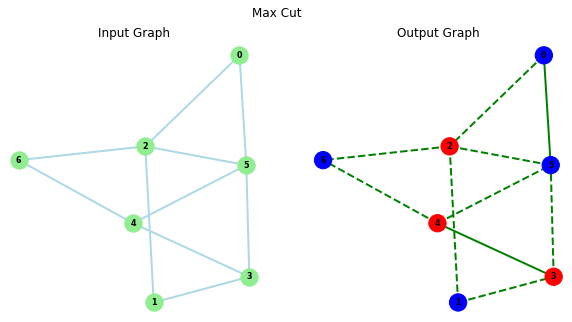

In [4]:
# Build a graph
V = list(range(7))
E = [(0, 5), (0, 2), (1, 2), (1, 3), (2, 5), (2, 6), (3, 5), (3, 4), (4, 5), (4, 6)]
W = [2, 3, 5, 1, 2, 3, 6, 2, 5, 3]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

# Normalize weights and build dictionary
W = [W[i]/sum(W) for i in range(len(W))]
W = {E[i]: W[i] for i in range(len(E))}

# Initialize classical optimization
optimal_z = '0' * len(V)
optimal_cost = 0

# Loop through all values
for z in range(2 ** len(V)):
    
    # Convert to bitstr
    bits = format(z, '0' + str(len(V)) + 'b')
    
    # Evaluate cost
    cost = 0
    for edge in E:
        if bits[edge[0]] != bits[edge[1]]:
            cost -= W[edge]
    
    # Compare with current minimum
    if cost < optimal_cost:
        optimal_z = format(z, '0' + str(len(V)) + 'b')
        optimal_cost = cost

# Color code output
color_map = []
for i in range(len(G.nodes)):
    if optimal_z[i] == '0':
        color_map.append('blue')
    else:
        color_map.append('red')

# Show cut edges as dashed
cuts = []
for e in G.edges:
    if optimal_z[e[0]] == optimal_z[e[1]]:
        cuts.append('solid')
    else:
        cuts.append('dashed')

# Plot input graph
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Max Cut')
plt.subplot(121)
ax = plt.gca()
ax.set_title('Input Graph')
pos = nx.drawing.layout.spring_layout(G)
nx.draw(G, with_labels=True, node_color='lightgreen', edge_color='lightblue', 
        style='solid', width=2, ax=ax, pos=pos, font_size=8, font_weight='bold')

# Plot output graph
plt.subplot(122)
ax = plt.gca()
ax.set_title('Output Graph')
nx.draw(G, with_labels=True, node_color=color_map, edge_color='green',
        style=cuts, width=2, ax=ax, pos=pos, font_size=8, font_weight='bold')

Now, let us look at the QAOA result.

Sampled Output: 1100011
Minimum Cost: -0.875
Expectation Value: -0.6574668884277344


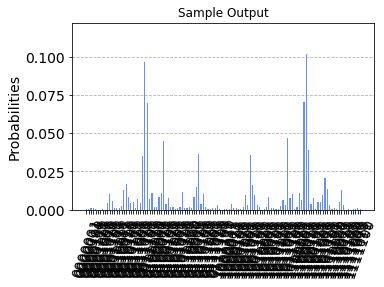

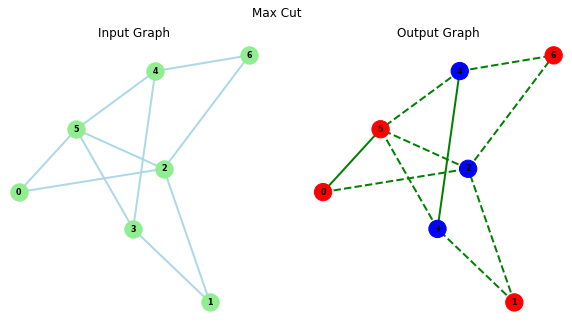

In [5]:
# Create MaxCut object and run
obj = MaxCut(V, W)
obj.visualize_output()

Observe that both the classically expected and QAOA results are identical as expected (except the *'red'* and *'blue'* colourings may be inverted). The QAOA engine also plots a histogram of the sampled values. Two strong peaks can be observed here. These correspond to the solution above and the one obtained by inverting all the colours, which is equally correct.

## 5. Noisy Max Cut
In this section, we shall add in a noise model to our simulation. This is easily done by using the __noise_model__ keyword while initializing the __MaxCut__ class. We shall use the mock noise models for the IBM quantum devices provided with qiskit. To avoid an overly long simulation time, we shall use a simple 4-vertex linear graph.

In [6]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import QasmSimulator

Sampled Output: 1010
Minimum Cost: -1.0
Expectation Value: -0.6115519205729167


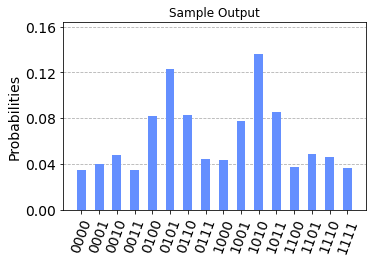

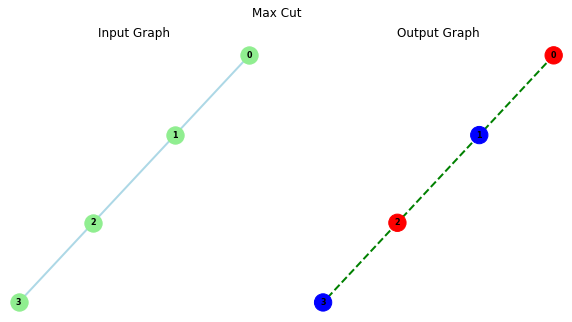

In [7]:
# Build linear graph
V = list(range(4))
E = [(i, i+1) for i in range(3)]
W = [1, 2, 3]
W = [W[i]/sum(W) for i in range(len(W))]
W = {E[i]: W[i] for i in range(len(E))}

# Build noisy backend
device_backend = FakeVigo()
backend = QasmSimulator.from_backend(device_backend)

# Run QAOA
obj = MaxCut(V, W, backend=backend)
obj.visualize_output()

## 6. The Max Clique Problem
The code files included in this repository also includes a solution of the Max Clique problem. This is done to demonstrate code-reusability in the sense that the QAOA engine developed in __qaoa_engine.py__ is sufficiently general to be able to solve other combinatorial optimization problems when supplied with the necessary cost function and Hamiltonians.

Given a graph $G = (V, E)$, a clique may be defined a fully-connected subgraph of $G$. The objective of max clique is to find the largest clique in a graph. The encoding scheme is again, fairly obvious. For each vertex $v \in V$, we assign $x_v = 1$ if $v$ is included in the largest clique and $x_v = 0$ otherwise. I shall not provide a detailed explanation for the cost Hamiltonian, but I will instead state the same below and refer the interested reader to [3].

$$H_C = \sum_n Z_n + \sum_{(a, b) \in \bar{G}} (Z_a \otimes Z_b - Z_a -Z_b)$$

In the above, $(a, b) \in \bar{G}$, where $\bar{G}$ denotes the anti-graph of $G$. For the mixer Hamiltonian, we shall again use the default one. It is to be noted that the Max Clique QAOA implemented here does not always provide the correct answer, This is one of the caveats of QAOA, in the sense that it is after all an *'approximate'* optimization algorithm. In a practical situation, the optimal answer will typically have at least a reasonably high probability of measurement, if not the highest. A classical post processing step may then be added to evaluate the cost function for say, the top 10 outputs and hence, evaluate the optimal value.

In [8]:
from itertools import combinations

Sampled Output: 0111110
Minimum Cost: -10
Expectation Value: -7.045166015625


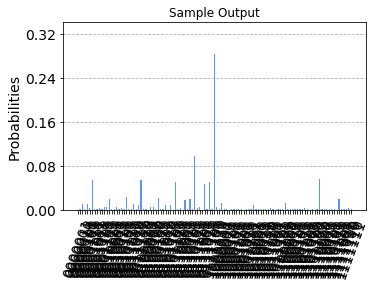

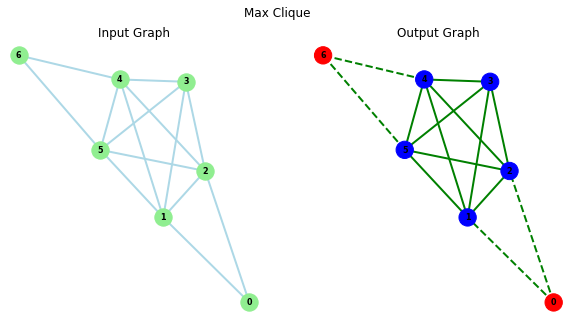

In [9]:
# Build a graph
V = list(range(7))
E = list(combinations(range(1, 6), 2)) + [(0, 1), (0, 2), (6, 4), (6, 5)]

# Run QAOA
obj = MaxClique(V, E)
obj.visualize_output()

## 7. Conclusions
In this document, I have described my implementation of a simple QAOA solver using IBM qiskit. Possible future experiments include, but are not limited to:

1. Evaluate and compare QAOA performance across multiple optimizers. For the above simulations, the COBYLA optimizer was used.
2. Change the default mixer ansatz and evaluate QAOA performance for alternative mixers.
3. Implementation of more combinatorial optimization problems (vertex cover, TSP, knapsack problem etc.)

In [10]:
import qiskit.tools.jupyter
%qiskit_version_table

## 8. References

1. Musty Thoughts. https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained. Accessed 16 Feb. 2021.
2. Musty Thoughts. https://www.mustythoughts.com/vqas-how-do-they-work. Accessed 16 Feb. 2021.
3. Website. https://lucaman99.github.io/new_blog/2020/mar16.html. Accessed 16 Feb. 2021.
4. Farhi, Edward, et al. “A Quantum Approximate Optimization Algorithm.” ArXiv:1411.4028 [Quant-Ph], Nov. 2014. arXiv.org, http://arxiv.org/abs/1411.4028.
5. Lucas, Andrew. “Ising Formulations of Many NP Problems.” Frontiers in Physics, vol. 2, 2014. DOI.org (Crossref), doi:10.3389/fphy.2014.00005.